# Create a Python Virtual Environment (Recommend)
>> python -m venv venv

only need to execute it once on your cmd

After venv has been created, activate it on cmd using command:
1. On Unix or MacOS
>> source venv/bin/activate
2. On Windows
>> venv/Scripts/activate

### Then install necessary packages
>> pip install opencv-python PyWavelets numpy matplotlib pandas

# Digital Watermarking using 4-level DWT on host image and 2-level SVD on both host and watermark image
Constraint:
1. Images will turn to grayscale
2. No encryption and decryption on watermark image
3. Host image will be resize to 512x512
4. Watermark image will be resize to 32x32
5. ...

In [1]:
import cv2, pywt, numpy as np
from pathlib import Path

In [2]:
# ========== 1. Load host & watermark ==========
host_path      = Path(r"images\chihuahua.webp")        # any 8-bit gray image, e.g. 512×512
watermark_path = Path(r"images\watermark.jpg")          # a *smaller* gray logo, e.g. 64×64
host_img       = cv2.imread(str(host_path), cv2.IMREAD_GRAYSCALE)
wm_img         = cv2.imread(str(watermark_path), cv2.IMREAD_GRAYSCALE)
if host_img is None or wm_img is None:
    raise FileNotFoundError("Check host / wm paths")

# optional: make watermark square & power-of-two for nicer shapes
host_img = cv2.resize(host_img, (512, 512), interpolation=cv2.INTER_AREA)
wm_img = cv2.resize(wm_img, (32, 32), interpolation=cv2.INTER_AREA)

cv2.imshow("Host", host_img)
cv2.imshow("Watermark", wm_img)
cv2.waitKey(0)

-1

In [3]:
# ========== 2. Forward DWTs ==========
wavelet, host_level = "haar", 4
wm_level = 1
alpha = 0.08 # can be adjusted to control watermark strength

coeffs_host = pywt.wavedec2(host_img, wavelet=wavelet, level=host_level)
cA4, detail_host   = coeffs_host[0], coeffs_host[1:]        # host coeff stack
cH4, cV4, cD4 = detail_host[0]  

# ========== 3. SVDs ==========
# ---------- i. First-level SVDs ----------
U1_h, S1_h_vec, V1_hT = np.linalg.svd(cA4, full_matrices=False)
U1_w, S1_w_vec, V1_wT = np.linalg.svd(wm_img,  full_matrices=False)

# ---------- ii. Second-level SVDs (on Σ₁) ----------
U2_h, S2_h_vec, V2_hT = np.linalg.svd(np.diag(S1_h_vec), full_matrices=False)
U2_w, S2_w_vec, V2_wT = np.linalg.svd(np.diag(S1_w_vec), full_matrices=False)

In [4]:
# ---------- 3. Embed in σ₂ domain ----------
# (resize watermark σ₂ to host length)
# S2_w_vec = np.resize(S2_w_vec, S2_h_vec.shape)
S2_emb   = S2_h_vec + alpha * S2_w_vec

# ---------- 4. Rebuild upward ----------
# level-2 → level-1
S1_emb = U2_h @ np.diag(S2_emb) @ V2_hT
# level-1 → spatial sub-band
cA4_emb = U1_h @ S1_emb @ V1_hT

In [5]:
# ========== 4. Inverse DWT ⇒ watermarked image ==========
detail_host[0] = (cH4, cV4, cD4)
coeff_emb  = [cA4_emb] + detail_host


watermarked_img = (
    pywt.waverec2(coeff_emb, wavelet)
    .clip(0, 255)
    .astype(np.uint8)
)
cv2.imwrite("watermarked.png", watermarked_img)
print("✅ Watermarked image saved → watermarked.png")

cv2.imshow("Watermarked Image", watermarked_img)
cv2.waitKey(0)

✅ Watermarked image saved → watermarked.png


-1

Ignore comment cell

In [6]:
# # ========== 6. Extract watermark & BER ==========
# # (In practice, start from an attacked/received image.)
# wmd_path      = Path(r"watermarked.png")  # path to the watermarked image
# wmd_img         = cv2.imread(str(wmd_path), cv2.IMREAD_GRAYSCALE)

# if wmd_img is None:
#     raise FileNotFoundError("Check wmd path")

# wmd_img = cv2.resize(wmd_img, (512, 512), interpolation=cv2.INTER_AREA)

# coeffs_rcv            = pywt.wavedec2(wmd_img, wavelet=wavelet, level=host_level)
# cA4_rcv, det_rcv      = coeffs_rcv[0], coeffs_rcv[1:]

# # 1️⃣ first-level SVD on received band
# U1_r, S1_r_vec, V1_rT = np.linalg.svd(cA4_rcv, full_matrices=False)

# # 2️⃣ second-level SVD on Σ₁ʳ
# U2_r, S2_r_vec, V2_rT = np.linalg.svd(np.diag(S1_r_vec), full_matrices=False)

# # 3️⃣ recover wm σ₂
# S2_w_hat = (S2_r_vec - S2_h_vec) / alpha

# # ---- 4. Rebuild watermark estimate ----
# # Build level-1 singular values matrix first
# S1_w_hat = U2_w @ np.diag(S2_w_hat) @ V2_wT

# # Then rebuild the watermark image
# wm_rcv_img = U1_w @ S1_w_hat @ V1_wT
# wm_rcv_img = np.clip(wm_rcv_img, 0, 255).astype(np.uint8)

# cv2.imwrite("wm_extracted.png", wm_rcv_img)
# print("✅ Extracted watermark saved → wm_extracted.png")

# cv2.imshow("Extracted Watermark", wm_rcv_img)
# cv2.waitKey(0)

In [7]:
# # ========== 5. Metrics ==========
# def psnr(a, b, max_val=255.0):
#     mse = np.mean((a.astype(np.float32) - b.astype(np.float32)) ** 2)
#     return 20 * np.log10(max_val) - 10 * np.log10(mse)

# orig_bits = (wm_img > 127).astype(np.uint8)
# recv_bits = (wm_rcv_img[:wm_img.shape[0], :wm_img.shape[1]] > 127).astype(np.uint8)
# ber       = np.mean(orig_bits != recv_bits)
# print(f"BER  : {ber:.4f}")
# print(f"PSNR : {psnr(host_img, wmd_img):.2f} dB (cover ↔ watermarked)")

In [10]:
# ========== 6. Extract watermark & BER for Multiple Attacked Images ==========
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# List of attacked watermarked images
attacked_images = [
    "watermarked.png",           # Original watermarked
    "jpg_watermarked.jpg",        # Add your attacked images here
    "ig_watermarked.png",         # Example names
    "ss_watermarked.png",
    "ss_new_watermarked.png",
    "wa_marked.jpg",
    "wa_ss_watermarked.jpg",
    "watermarked_256.png",
    "watermarked_1080.png",
    "light_noise_watermarked.jpg",
    "noise_watermarked.jpg"
]

# Initialize results storage
results = []
extracted_watermarks = []

def psnr(a, b, max_val=255.0):
    mse = np.mean((a.astype(np.float32) - b.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val) - 10 * np.log10(mse)

print("Processing attacked watermarked images...")
print("=" * 60)

for i, img_name in enumerate(attacked_images):
    wmd_path = Path(img_name)
    
    # Skip if file doesn't exist
    if not wmd_path.exists():
        print(f"⚠️  Skipping {img_name} - file not found")
        continue
    
    print(f"\n🔍 Processing: {img_name}")
    
    # Load attacked watermarked image
    wmd_img = cv2.imread(str(wmd_path), cv2.IMREAD_GRAYSCALE)
    if wmd_img is None:
        print(f"❌ Failed to load {img_name}")
        continue
    
    wmd_img = cv2.resize(wmd_img, (512, 512), interpolation=cv2.INTER_AREA)
    
    # Extract watermark using double SVD
    coeffs_rcv = pywt.wavedec2(wmd_img, wavelet=wavelet, level=host_level)
    cA4_rcv, det_rcv = coeffs_rcv[0], coeffs_rcv[1:]
    
    # 1️⃣ first-level SVD on received band
    U1_r, S1_r_vec, V1_rT = np.linalg.svd(cA4_rcv, full_matrices=False)
    
    # 2️⃣ second-level SVD on Σ₁ʳ
    U2_r, S2_r_vec, V2_rT = np.linalg.svd(np.diag(S1_r_vec), full_matrices=False)
    
    # 3️⃣ recover wm σ₂
    min_len = min(len(S2_r_vec), len(S2_h_vec))
    S2_w_hat = (S2_r_vec[:min_len] - S2_h_vec[:min_len]) / alpha
    
    # ---- 4. Rebuild watermark estimate ----
    # Pad if necessary
    if len(S2_w_hat) < len(S2_w_vec):
        S2_w_hat = np.pad(S2_w_hat, (0, len(S2_w_vec) - len(S2_w_hat)), 'constant')
    else:
        S2_w_hat = S2_w_hat[:len(S2_w_vec)]
    
    # Build level-1 singular values matrix first
    S1_w_hat = U2_w @ np.diag(S2_w_hat) @ V2_wT
    
    # Then rebuild the watermark image
    wm_rcv_img = U1_w @ S1_w_hat @ V1_wT
    wm_rcv_img = np.clip(wm_rcv_img, 0, 255).astype(np.uint8)
    
    # Save extracted watermark
    extracted_name = f"extracted_wm_{i:02d}_{Path(img_name).stem}.png"
    cv2.imwrite(extracted_name, wm_rcv_img)
    
    # Calculate metrics
    orig_bits = (wm_img > 127).astype(np.uint8)
    recv_bits = (wm_rcv_img[:wm_img.shape[0], :wm_img.shape[1]] > 127).astype(np.uint8)
    ber = np.mean(orig_bits != recv_bits)
    psnr_value = psnr(host_img, wmd_img)
    wm_psnr = psnr(wm_img, wm_rcv_img[:wm_img.shape[0], :wm_img.shape[1]])
    
    # Store results
    results.append({
        'Image': Path(img_name).stem,
        'BER': ber,
        'Host PSNR (dB)': psnr_value,
        'WM PSNR (dB)': wm_psnr,
        'Extracted File': extracted_name
    })
    
    extracted_watermarks.append((wmd_img, wm_rcv_img, img_name))
    
    print(f"   BER: {ber:.4f}")
    print(f"   Host PSNR: {psnr_value:.2f} dB")
    print(f"   WM PSNR: {wm_psnr:.2f} dB")
    print(f"   Extracted: {extracted_name}")

print("\n" + "=" * 60)
print("✅ Extraction completed for all images")

Processing attacked watermarked images...

🔍 Processing: watermarked.png
   BER: 0.4492
   Host PSNR: 52.92 dB
   WM PSNR: 7.67 dB
   Extracted: extracted_wm_00_watermarked.png

🔍 Processing: jpg_watermarked.jpg
   BER: 0.0762
   Host PSNR: 42.73 dB
   WM PSNR: 16.30 dB
   Extracted: extracted_wm_01_jpg_watermarked.png

🔍 Processing: ig_watermarked.png
   BER: 0.0732
   Host PSNR: 44.06 dB
   WM PSNR: 16.30 dB
   Extracted: extracted_wm_02_ig_watermarked.png

🔍 Processing: ss_watermarked.png
   BER: 0.1299
   Host PSNR: 29.74 dB
   WM PSNR: 13.49 dB
   Extracted: extracted_wm_03_ss_watermarked.png

🔍 Processing: ss_new_watermarked.png
   BER: 0.0605
   Host PSNR: 34.21 dB
   WM PSNR: 15.83 dB
   Extracted: extracted_wm_04_ss_new_watermarked.png

🔍 Processing: wa_marked.jpg
   BER: 0.8047
   Host PSNR: 12.20 dB
   WM PSNR: 1.91 dB
   Extracted: extracted_wm_05_wa_marked.png

🔍 Processing: wa_ss_watermarked.jpg
   BER: 0.0322
   Host PSNR: 40.88 dB
   WM PSNR: 16.96 dB
   Extracted: extr

📊 COMPARISON STATISTICS
                  Image    BER  Host PSNR (dB)  WM PSNR (dB)                              Extracted File
            watermarked 0.5820         52.9190        5.2350             extracted_wm_00_watermarked.png
        jpg_watermarked 0.3916         42.7263        7.1986         extracted_wm_01_jpg_watermarked.png
         ig_watermarked 0.3896         44.0624        7.2029          extracted_wm_02_ig_watermarked.png
         ss_watermarked 0.3350         29.7440        8.0184          extracted_wm_03_ss_watermarked.png
     ss_new_watermarked 0.3457         34.2131        7.8737      extracted_wm_04_ss_new_watermarked.png
              wa_marked 0.6445         12.1986        2.7140               extracted_wm_05_wa_marked.png
      wa_ss_watermarked 0.3506         40.8832        7.7491       extracted_wm_06_wa_ss_watermarked.png
        watermarked_256 0.4258         34.7469        6.7169         extracted_wm_07_watermarked_256.png
       watermarked_1080 0.3896 

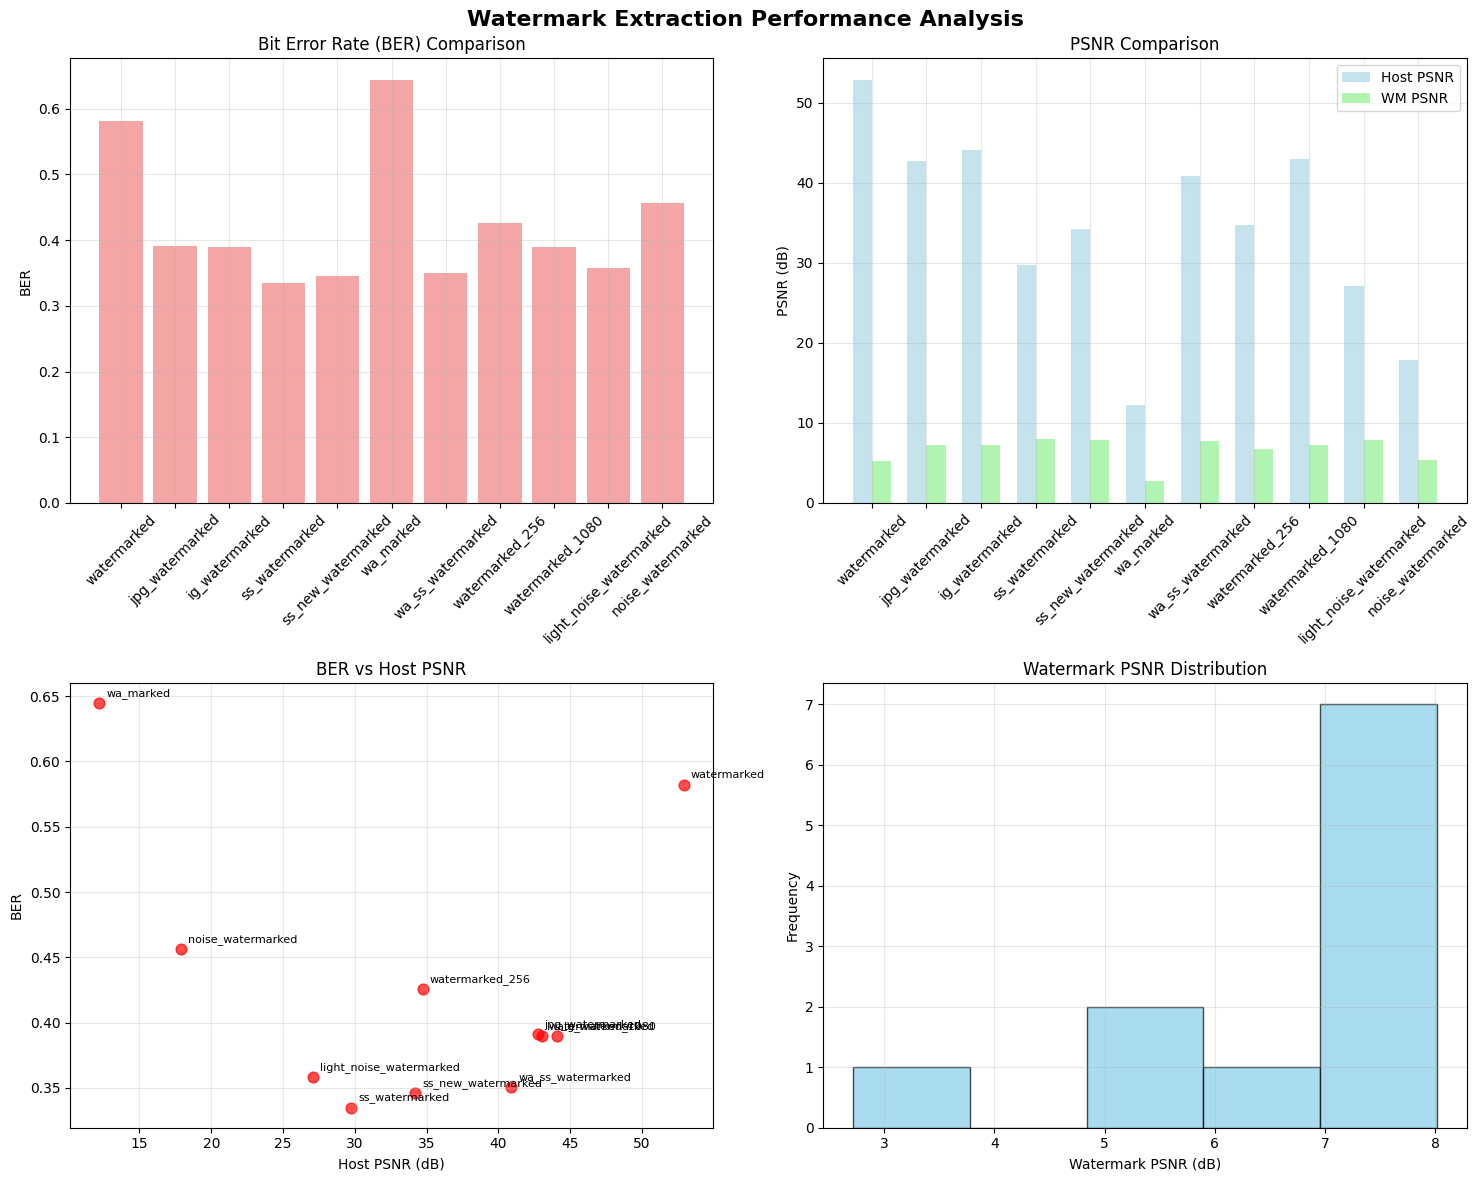

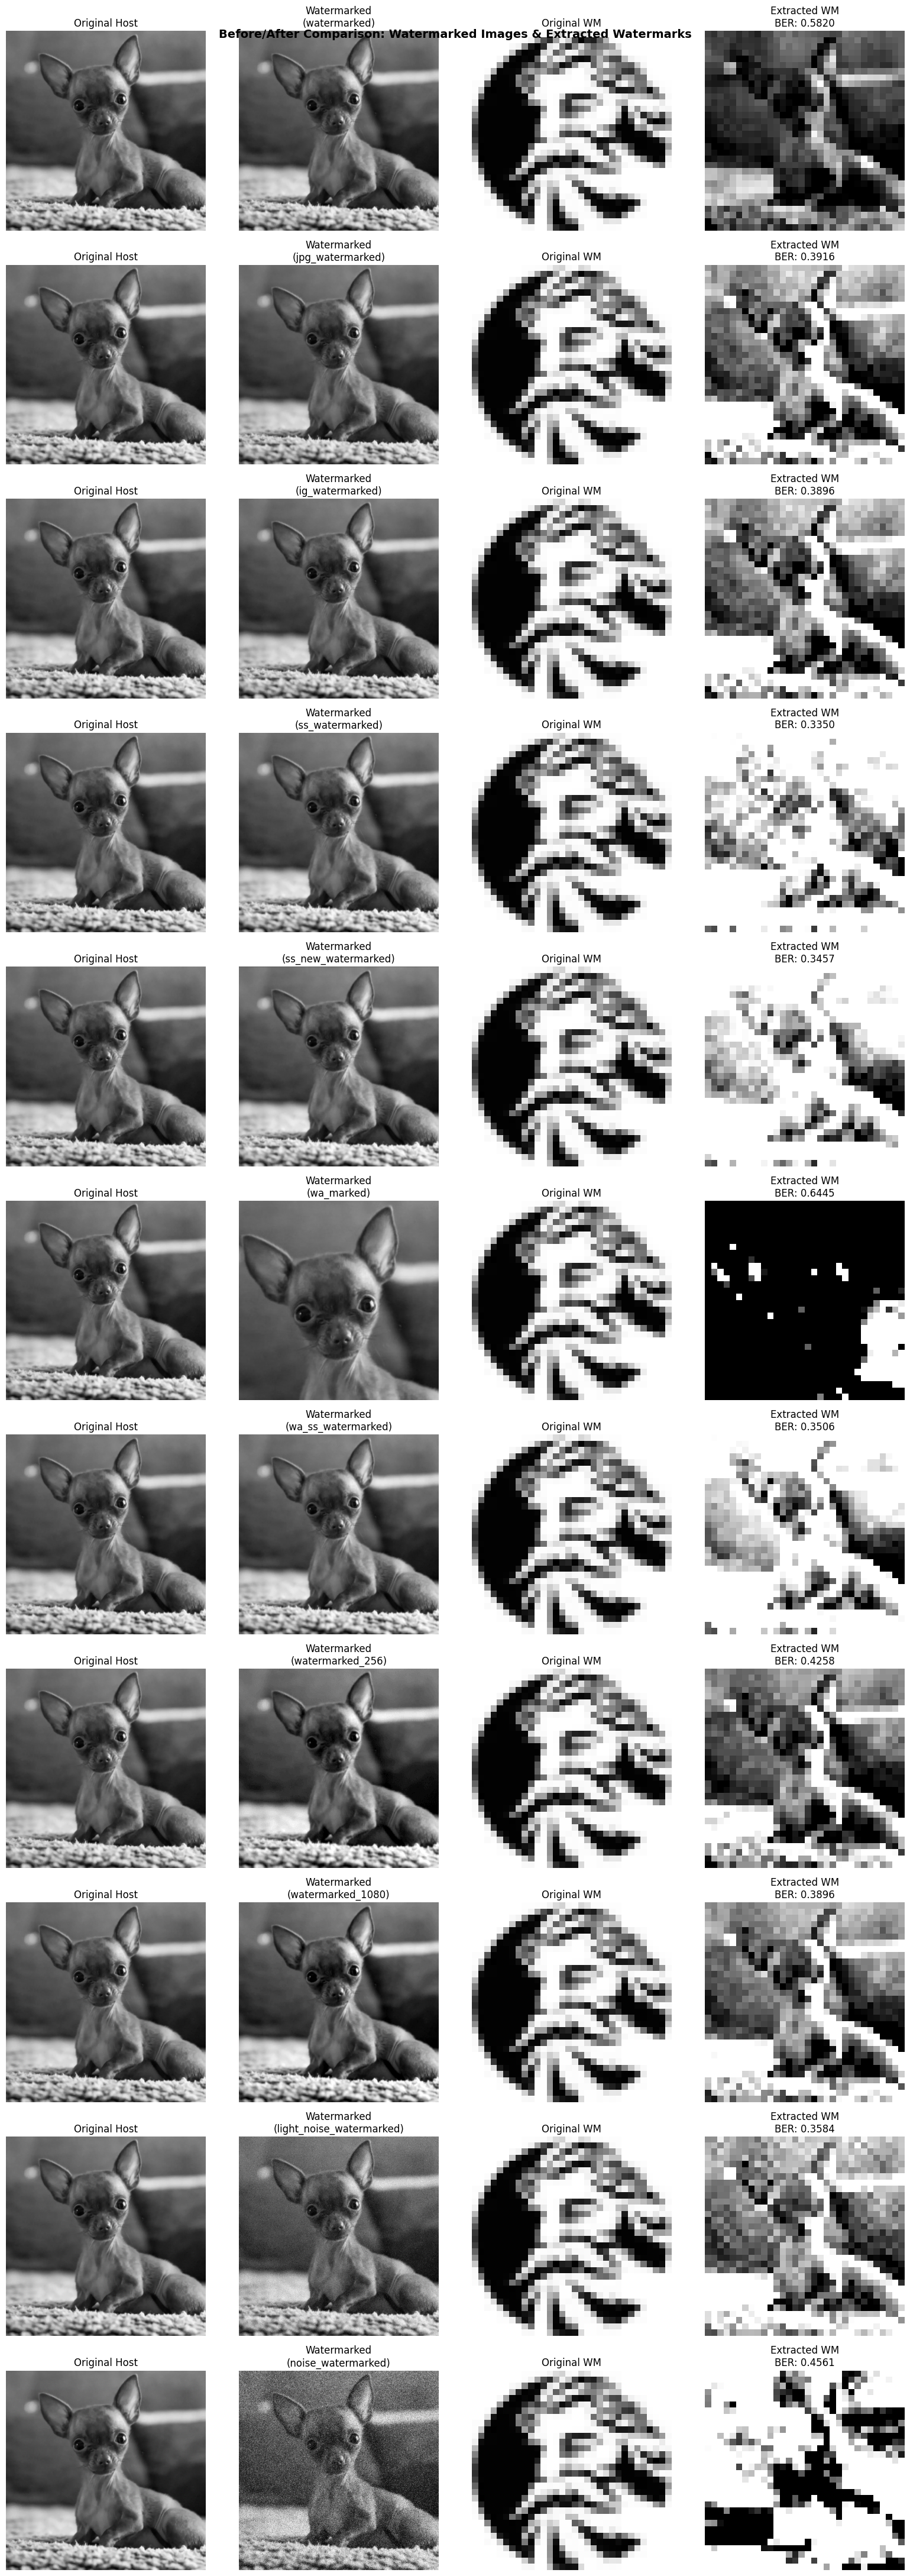


💾 Results saved to: watermark_extraction_results.csv


In [9]:
# ========== 7. Comparison Statistics & Visualization ==========

# Create results DataFrame
df_results = pd.DataFrame(results)
print("📊 COMPARISON STATISTICS")
print("=" * 80)
print(df_results.to_string(index=False, float_format='%.4f'))

# Summary statistics
print("\n📈 SUMMARY STATISTICS")
print("=" * 50)
print(f"Average BER: {df_results['BER'].mean():.4f} ± {df_results['BER'].std():.4f}")
print(f"Average Host PSNR: {df_results['Host PSNR (dB)'].mean():.2f} ± {df_results['Host PSNR (dB)'].std():.2f} dB")
print(f"Average WM PSNR: {df_results['WM PSNR (dB)'].mean():.2f} ± {df_results['WM PSNR (dB)'].std():.2f} dB")
print(f"Best BER: {df_results['BER'].min():.4f} ({df_results.loc[df_results['BER'].idxmin(), 'Image']})")
print(f"Worst BER: {df_results['BER'].max():.4f} ({df_results.loc[df_results['BER'].idxmax(), 'Image']})")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Watermark Extraction Performance Analysis', fontsize=16, fontweight='bold')

# BER comparison
axes[0,0].bar(df_results['Image'], df_results['BER'], color='lightcoral', alpha=0.7)
axes[0,0].set_title('Bit Error Rate (BER) Comparison')
axes[0,0].set_ylabel('BER')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# PSNR comparison
x_pos = np.arange(len(df_results))
width = 0.35
axes[0,1].bar(x_pos - width/2, df_results['Host PSNR (dB)'], width, 
              label='Host PSNR', color='lightblue', alpha=0.7)
axes[0,1].bar(x_pos + width/2, df_results['WM PSNR (dB)'], width, 
              label='WM PSNR', color='lightgreen', alpha=0.7)
axes[0,1].set_title('PSNR Comparison')
axes[0,1].set_ylabel('PSNR (dB)')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(df_results['Image'], rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# BER vs Host PSNR scatter
axes[1,0].scatter(df_results['Host PSNR (dB)'], df_results['BER'], 
                  c='red', alpha=0.7, s=60)
axes[1,0].set_xlabel('Host PSNR (dB)')
axes[1,0].set_ylabel('BER')
axes[1,0].set_title('BER vs Host PSNR')
axes[1,0].grid(True, alpha=0.3)

# Add image labels to scatter plot
for i, txt in enumerate(df_results['Image']):
    axes[1,0].annotate(txt, (df_results['Host PSNR (dB)'].iloc[i], df_results['BER'].iloc[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

# Watermark PSNR distribution
axes[1,1].hist(df_results['WM PSNR (dB)'], bins=min(5, len(df_results)), 
               color='skyblue', alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Watermark PSNR (dB)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Watermark PSNR Distribution')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display before/after images
if extracted_watermarks:
    n_images = len(extracted_watermarks)
    fig, axes = plt.subplots(n_images, 4, figsize=(16, 4*n_images))
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Before/After Comparison: Watermarked Images & Extracted Watermarks', 
                 fontsize=14, fontweight='bold')
    
    for i, (wmd_img, wm_extracted, img_name) in enumerate(extracted_watermarks):
        # Original host
        axes[i,0].imshow(host_img, cmap='gray')
        axes[i,0].set_title('Original Host')
        axes[i,0].axis('off')
        
        # Watermarked/Attacked
        axes[i,1].imshow(wmd_img, cmap='gray')
        axes[i,1].set_title(f'Watermarked\n({Path(img_name).stem})')
        axes[i,1].axis('off')
        
        # Original watermark
        axes[i,2].imshow(wm_img, cmap='gray')
        axes[i,2].set_title('Original WM')
        axes[i,2].axis('off')
        
        # Extracted watermark
        axes[i,3].imshow(wm_extracted, cmap='gray')
        axes[i,3].set_title(f'Extracted WM\nBER: {results[i]["BER"]:.4f}')
        axes[i,3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Save results to CSV
df_results.to_csv('watermark_extraction_results.csv', index=False)
print(f"\n💾 Results saved to: watermark_extraction_results.csv")